In [1]:
import numpy as np
import cv2
from PIL import Image
import torch
from magic_pen.config import SEED
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from magic_pen.utils_io import load_levircd_sample

from magic_pen.data.loader import BiTemporalDataset
from commons.constants import NamedDataset
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform

from segment_any_change.masks.mask_process import extract_object_from_batch
from segment_any_change.config_run import ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.eval import MetricEngine
from segment_any_change.inference import load_partial_ds
from segment_any_change.config_run import load_default_exp_params
from segment_any_change.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample, load_img
from segment_any_change.inference import partial_inference, infer_on_sample

In [2]:
pair_img = load_levircd_sample(size=None, data_type="test", seed=8)
path_label,path_A, path_B = pair_img.iloc[0]

In [3]:
img_B = load_img(path_B)
img_A = load_img(path_A)

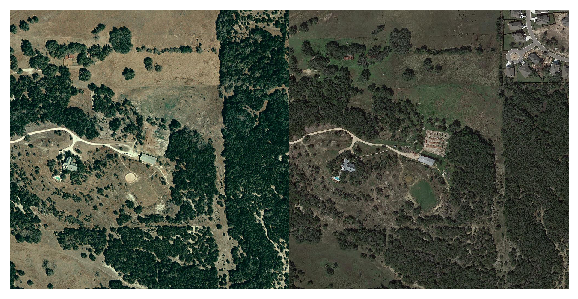

In [4]:
show_pair_img(img_A, img_B)

### Infer on batch

In [12]:
params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=True,
    n_job_by_node=2,
    th_change_proposals=50,
    prompt_type="grid",
    n_prompt=10,
    loc="random",
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95
)
params = load_exp_params(**params)
print(params)

res = partial_inference(params,
    ds_dtype="test",
    dummy=False,
    indices=np.arange(6),
    return_batch=True,
    in_metrics=None)

2024-06-20 14:53:23,377 - INFO ::  build vit_b BiSam


ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', prompt_type='grid', n_prompt=10, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240620_145323', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')
DATASET SUBSET : 6


Processing:   0%|                                                                                                                  | 0/3 [00:00<?, ?it/s]2024-06-20 14:53:24,817 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
DTYPE input model torch.float32
Function forward Took 5.8119 seconds
sparse_embeddings: torch.Size([4, 9, 2, 256])
dense_embeddings: torch.Size([4, 9, 256, 64, 64])
--in transformer--
src : torch.Size([4, 9, 256, 64, 64])
pos_src : torch.Size([4, 9, 256, 64, 64])
tokens : torch.Size([4, 9, 7, 256])


2024-06-20 14:53:31,384 - INFO ::  Function generate Took 6.5650 seconds
2024-06-20 14:53:31,407 - INFO ::  Function temporal_matching_torch Took 0.0213 seconds
2024-06-20 14:53:31,466 - INFO ::  Function temporal_matching_torch Took 0.0583 seconds
2024-06-20 14:53:31,469 - INFO ::  Function proposal_matching_nms Took 0.0005 seconds
2024-06-20 14:53:31,488 - INFO ::  Function temporal_matching_torch Took 0.0175 seconds
2024-06-20 14:53:31,506 - INFO ::  Function temporal_matching_torch Took 0.0176 seconds
2024-06-20 14:53:31,507 - INFO ::  Function proposal_matching_nms Took 0.0001 seconds
2024-06-20 14:53:31,511 - INFO ::  Function run Took 6.6924 seconds


Function predict_masks_batch Took 0.7285 seconds
OUT MODEL : torch.Size([4, 9, 3, 256, 256])
:: raw masks : 27 ::
 filter iou_th : 7
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
:: raw masks : 27 ::
 filter iou_th : 4
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
:: raw masks : 27 ::
 filter iou_th : 7
 filter stability_score : 2
 filter mask_threshold : 2
ATTACH 2 masks
:: raw masks : 27 ::
 filter iou_th : 4
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
NMS masks fusion
masks torch.Size([2, 2, 256, 256])
masks i A torch.Size([0, 256, 256])
masks i B torch.Size([2, 256, 256])
ci torch.Size([2, 2])
bboxes torch.Size([2, 2, 4])
ious torch.Size([2, 2])
masks_logits torch.Size([2, 2, 256, 256])
NMS masks fusion
masks torch.Size([2, 0, 256, 256])
masks i A torch.Size([0, 256, 256])
masks i B torch.Size([0, 256, 256])
ci torch.Size([2, 0])
bboxes torch.Size([2, 0, 4])
ious torch.Size([2, 0])
masks_logits torch.Size([2,

Processing:  33%|███████████████████████████████████▎                                                                      | 1/3 [00:07<00:14,  7.25s/it]2024-06-20 14:53:31,955 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
DTYPE input model torch.float32
Function forward Took 5.4130 seconds
sparse_embeddings: torch.Size([4, 9, 2, 256])
dense_embeddings: torch.Size([4, 9, 256, 64, 64])
--in transformer--
src : torch.Size([4, 9, 256, 64, 64])
pos_src : torch.Size([4, 9, 256, 64, 64])
tokens : torch.Size([4, 9, 7, 256])


2024-06-20 14:53:38,143 - INFO ::  Function generate Took 6.1864 seconds
2024-06-20 14:53:38,203 - INFO ::  Function temporal_matching_torch Took 0.0584 seconds
2024-06-20 14:53:38,222 - INFO ::  Function temporal_matching_torch Took 0.0177 seconds
2024-06-20 14:53:38,223 - INFO ::  Function proposal_matching_nms Took 0.0004 seconds
2024-06-20 14:53:38,246 - INFO ::  Function temporal_matching_torch Took 0.0175 seconds
2024-06-20 14:53:38,264 - INFO ::  Function temporal_matching_torch Took 0.0177 seconds
2024-06-20 14:53:38,265 - INFO ::  Function proposal_matching_nms Took 0.0001 seconds
2024-06-20 14:53:38,272 - INFO ::  Function run Took 6.3153 seconds


Function predict_masks_batch Took 0.7523 seconds
OUT MODEL : torch.Size([4, 9, 3, 256, 256])
:: raw masks : 27 ::
 filter iou_th : 11
 filter stability_score : 3
 filter mask_threshold : 3
ATTACH 2 masks
:: raw masks : 27 ::
 filter iou_th : 4
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
:: raw masks : 27 ::
 filter iou_th : 6
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
:: raw masks : 27 ::
 filter iou_th : 0
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
NMS masks fusion
masks torch.Size([2, 2, 256, 256])
masks i A torch.Size([2, 256, 256])
masks i B torch.Size([0, 256, 256])
ci torch.Size([2, 2])
bboxes torch.Size([2, 2, 4])
ious torch.Size([2, 2])
masks_logits torch.Size([2, 2, 256, 256])
NMS masks fusion
masks torch.Size([2, 0, 256, 256])
masks i A torch.Size([0, 256, 256])
masks i B torch.Size([0, 256, 256])
ci torch.Size([2, 0])
bboxes torch.Size([2, 0, 4])
ious torch.Size([2, 0])
masks_logits torch.Size([2

Processing:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:13<00:06,  6.92s/it]2024-06-20 14:53:38,593 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
DTYPE input model torch.float32
Function forward Took 5.5372 seconds
sparse_embeddings: torch.Size([4, 9, 2, 256])
dense_embeddings: torch.Size([4, 9, 256, 64, 64])
--in transformer--
src : torch.Size([4, 9, 256, 64, 64])
pos_src : torch.Size([4, 9, 256, 64, 64])
tokens : torch.Size([4, 9, 7, 256])


2024-06-20 14:53:44,909 - INFO ::  Function generate Took 6.3149 seconds
2024-06-20 14:53:44,964 - INFO ::  Function temporal_matching_torch Took 0.0515 seconds
2024-06-20 14:53:45,033 - INFO ::  Function temporal_matching_torch Took 0.0674 seconds
2024-06-20 14:53:45,035 - INFO ::  Function proposal_matching_nms Took 0.0005 seconds


Function predict_masks_batch Took 0.7574 seconds
OUT MODEL : torch.Size([4, 9, 3, 256, 256])
:: raw masks : 27 ::
 filter iou_th : 7
 filter stability_score : 1
 filter mask_threshold : 1
ATTACH 1 masks
:: raw masks : 27 ::
 filter iou_th : 5
 filter stability_score : 1
 filter mask_threshold : 1
ATTACH 1 masks
:: raw masks : 27 ::
 filter iou_th : 5
 filter stability_score : 1
 filter mask_threshold : 1
ATTACH 1 masks
:: raw masks : 27 ::
 filter iou_th : 1
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
NMS masks fusion
masks torch.Size([2, 1, 256, 256])
masks i A torch.Size([1, 256, 256])
masks i B torch.Size([1, 256, 256])
ci torch.Size([2, 1])
bboxes torch.Size([2, 1, 4])
ious torch.Size([2, 1])
masks_logits torch.Size([2, 1, 256, 256])


2024-06-20 14:53:45,116 - INFO ::  Function temporal_matching_torch Took 0.0793 seconds
2024-06-20 14:53:45,141 - INFO ::  Function temporal_matching_torch Took 0.0236 seconds
2024-06-20 14:53:45,143 - INFO ::  Function proposal_matching_nms Took 0.0004 seconds
2024-06-20 14:53:45,147 - INFO ::  Function run Took 6.5527 seconds
Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.94s/it]


NMS masks fusion
masks torch.Size([2, 1, 256, 256])
masks i A torch.Size([1, 256, 256])
masks i B torch.Size([0, 256, 256])
ci torch.Size([2, 1])
bboxes torch.Size([2, 1, 4])
ious torch.Size([2, 1])
masks_logits torch.Size([2, 1, 256, 256])
update : classif
-


In [11]:
res[0].keys()

dict_keys(['preds', 'metrics', 'batch'])

In [13]:
for output in res:
    show_prediction_sample(output, idx=0)

KeyError: 'pred'

### Infer on sample

In [5]:
pair_img = load_levircd_sample(1, seed=8)
path_label,path_A, path_B = pair_img.iloc[0]

params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=True,
    n_job_by_node=2,
    th_change_proposals=50,
    prompt_type="grid",
    n_prompt=1024,
    loc="random",
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95
)
params = load_exp_params(**params)
print(params)
model = choose_model(is_debug=False, params=params)

output = infer_on_sample(A_path=path_A,
                B_path=path_B, 
                label_path=path_label,
                params=params,
                model=model)

2024-06-20 14:19:01,039 - INFO ::  build vit_b BiSam


ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', prompt_type='grid', n_prompt=1024, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240620_141901', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


2024-06-20 14:19:02,009 - INFO ::  === v2 ====


BATCH SIZE : 1 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
DTYPE input model torch.float32
Function forward Took 3.8243 seconds


RuntimeError: Tensors must have same number of dimensions: got 4 and 3

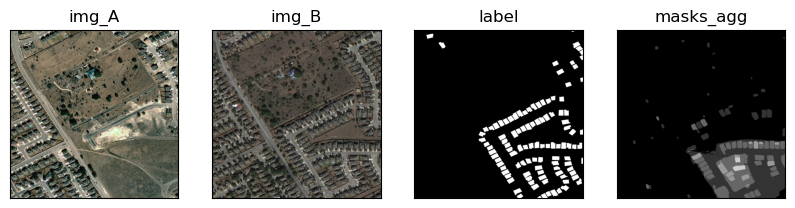

In [51]:
show_prediction_sample(output)

In [52]:
output.keys()

dict_keys(['pred', 'batch'])

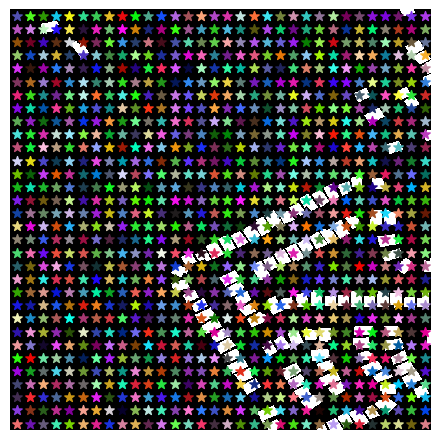

In [53]:
show_img(to_numpy(output["batch"]["label"].squeeze(0) > 0, transpose=False))
ax = plt.gca()

res = output["batch"]["point_coords"].squeeze(0)

color = [np.random.choice(range(256), size=3) / 256 for _ in range(len(res))]

pts = to_numpy(res,transpose=False)
for pt, co in zip(pts, color):
    ax.scatter(*pt, c=[co], marker='*', s=50)

* biais : pour les petits object, le points ont tendances à être samplés sur le bord
* forte variablité de résultats via pred_iou_thresh & pred_iou_thresh => préférer l'exhaustivitée des résultats.
* demander à l'auteur les paramètres utilisés.
* review `compute torchmetrics`